# Part 2

In [51]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image , ImageChops

%matplotlib inline

## Task A
### Replicating Inpaint Paper Results

In [2]:
# Used to compare inpainting results
def CompareResult(BlendingResult, S2, metric):
    if metric == "SSD":
        dif = BlendingResult.ravel() - S2.ravel()
        return np.dot(dif, dif)
    elif metric == "MSE":
        return np.square(np.subtract(S2.astype(int),BlendingResult.astype(int))).mean()
    
    print("[ERR]Incorrect metric")
    return -1

In [3]:
def create_inpaint_table(s2_dir, s1_dir, mask_dir):
    s1_list, telea_list, ns_list = [],[],[]
    fig,ax = plt.subplots(6,5, figsize=(13,10))
    
    for i, file in enumerate(zip(os.scandir(s2_dir),os.scandir(s1_dir),os.scandir(mask_dir))):
        s2 = cv2.imread(file[0].path)
        s1 = cv2.imread(file[1].path)
        s1_list.append(s1)
        mask = cv2.imread(file[2].path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
        telea = cv2.inpaint(s2,mask,50,cv2.INPAINT_TELEA)
        telea_list.append(telea)
        ns = cv2.inpaint(s2,mask,50,cv2.INPAINT_NS)
        ns_list.append(ns)
    
        for j in range(5):
            ax[i, j].axis('off')

        ax[i, 0].imshow(s2[:,:,::-1])
        ax[i, 1].imshow(mask,cmap='gray')
        ax[i, 2].imshow(s1[:,:,::-1])
        ax[i, 3].imshow(telea[:,:,::-1])
        ax[i, 4].imshow(ns[:,:,::-1])
    
    return s1_list, telea_list, ns_list

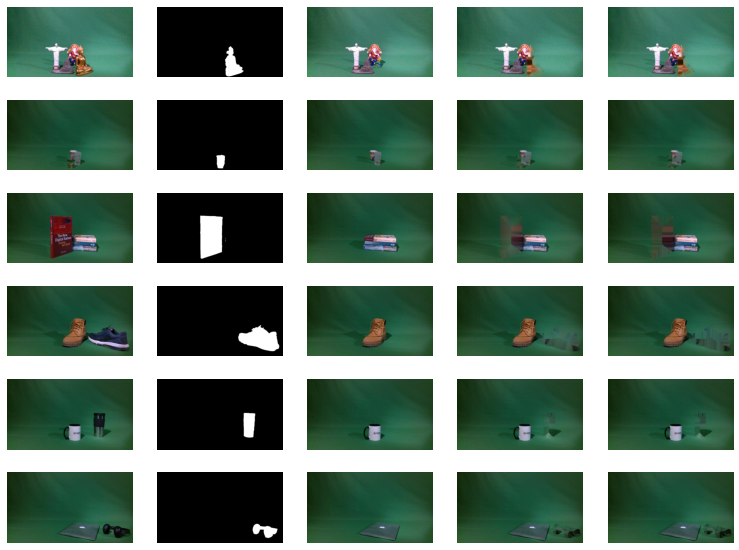

In [45]:
s2_dir = "inpaint_imgs/original_scene2"
s1_dir = "inpaint_imgs/original_scene1"
mask_dir = "inpaint_imgs/original_masks"
s1_list, telea_list, ns_list = create_inpaint_table(s2_dir, s1_dir, mask_dir)

In [52]:
# table with MSE
def create_mse_table(oc_list, categories, s1_list, telea_list, ns_list):
    # Print titles
    print("{:<13}{:<11}{:<20}{:<20}".format("", "Occlusion", "Telea", "NS"))

    for i, (truth, img_t, img_n, oc) in enumerate(zip(s1_list, telea_list, ns_list, oc_list)):
        telea_mse = CompareResult(img_t, truth, 'MSE')
        ns_mse = CompareResult(img_n, truth, 'MSE')
        print("{:<13}{:<11}{:<20}{:<20}".format(categories[i], oc, telea_mse, ns_mse))

categories = ["Statues", "Shooters", "Academic", "Footwear","Mugs", "Tech"]
occluded = ["oc", "oc", "oc", "no", "no", "no"]
create_mse_table(occluded, categories, s1_list, telea_list, ns_list)

             Occlusion  Telea               NS                  
Statues      oc         176.30990451388888  179.75815538194445  
Shooters     oc         21.372786458333334  20.424694733796297  
Academic     oc         134.85625           137.28863100405093  
Footwear     no         31.618821614583332  34.72445276331018   
Mugs         no         28.529319661458334  30.211561414930557  
Tech         no         48.02922634548611   52.98540943287037   


## Task B
### I) Evaluating Inpainting on New Dataset

In [42]:
# preprocess rgb masks
# valid masks are all green
green = (np.array([0,10,0]), np.array([0,255,0]))
directory = "inpaint_imgs/new_masks_rgb"

for i, file in enumerate(os.scandir(directory)):
    rgb_mask = cv2.imread(file.path)
    wb_mask = cv2.inRange(rgb_mask, green[0], green[1])
    cv2.imwrite("inpaint_imgs/new_masks/img"+str(i+1)+".png",wb_mask)
print('done')

done


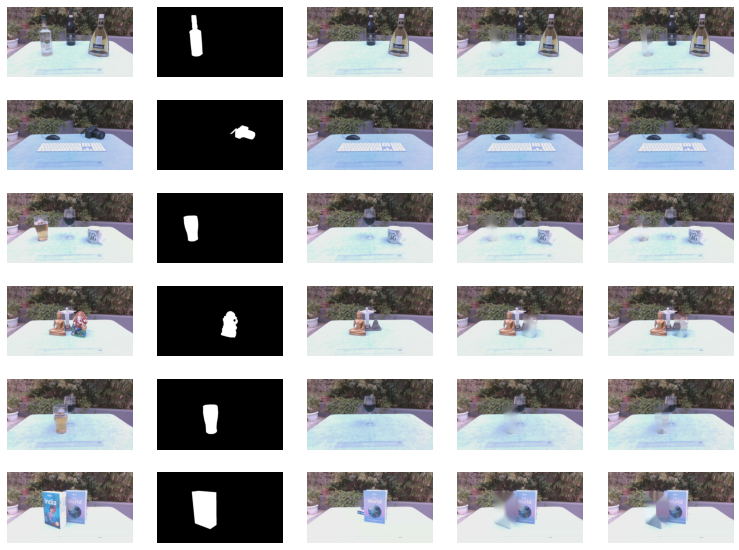

In [47]:
n_s2_dir = "inpaint_imgs/new_scene2"
n_s1_dir = "inpaint_imgs/new_scene1"
n_mask_dir = "inpaint_imgs/new_masks"
n_s1_list, n_telea_list, n_ns_list = create_inpaint_table(n_s2_dir, n_s1_dir, n_mask_dir)

In [53]:
new_categories = ["Bottles", "Electronics", "Cups", "Statues","Cups", "Books"]
tag = ["nw_no", "nw_no", "w_no", "w_no", "w_oc", "nw_oc"]
create_mse_table(tag, new_categories, n_s1_list, n_telea_list, n_ns_list)

             Occlusion  Telea               NS                  
Bottles      nw_no      73.66781358506944   84.89556676793981   
Electronics  nw_no      84.67842918113426   145.5227560763889   
Cups         w_no       117.59107277199074  123.95586588541667  
Statues      w_no       147.5934790943287   156.44811234085648  
Cups         w_oc       108.88221390335649  116.92723524305555  
Books        nw_oc      258.9800372540509   343.8428927951389   


### II) Analysing Effect of Changing Background

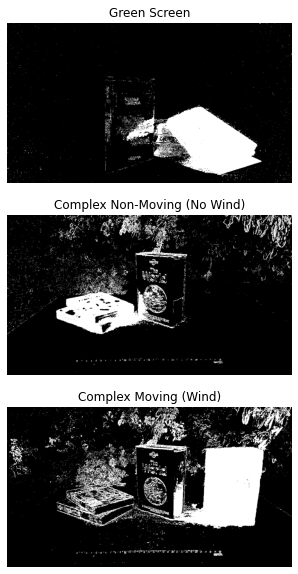

In [90]:
# Background subtraction
# to be performed on both moving backgrounds (from new dataset) and static backgrounds (from original)
# maybe do 3 instances; w and nw from new dataset and one image from the old
bg_remove_paths = ["COTSDataset/Part 2 - Multiple Objects/academic_book_oc/",
                   "COTSDataset/Part 3 - Complex Background/booksA_nw_no/",
                   "COTSDataset/Part 3 - Complex Background/booksA_w_no/"]
titles = ["Green Screen", "Complex Non-Moving (No Wind)", "Complex Moving (Wind)"]

fig,ax = plt.subplots(3,1, figsize=(16,10))
for i, path in enumerate(bg_remove_paths):
    mog2 = cv2.createBackgroundSubtractorMOG2()
    ax[i].set_title(titles[i])
    ax[i].axis('off')
    for j in range(1,4):
        img = cv2.imread(path+str(j)+"_colour.jpeg")
        diff = mog2.apply(img)
    ax[i].imshow(diff, cmap="gray")

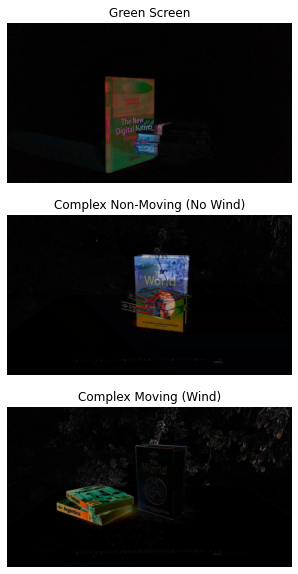

In [89]:
fig,ax = plt.subplots(3,1, figsize=(16,10))
for i, path in enumerate(bg_remove_paths):
    ax[i].set_title(titles[i])
    ax[i].axis('off')
    pil_test_img1 = Image.fromarray(cv2.imread(path+"1_colour.jpeg")[:,:,::-1])
    pil_test_img2 = Image.fromarray(cv2.imread(path+"2_colour.jpeg")[:,:,::-1])
    diff = ImageChops.difference(pil_test_img1, pil_test_img2)
    ax[i].imshow(diff)